In [107]:
from sodapy import Socrata
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [11]:
path = "data/311_Cases.csv"

In [13]:
df = pd.read_csv(path)

In [48]:
ssc_df = df[df['Category']=='Street and Sidewalk Cleaning'].copy()

In [50]:
ssc_df['Opened'] = pd.to_datetime(ssc_df['Opened'])
ssc_df['hour'] = ssc_df['Opened'].dt.hour
ssc_df['minute'] = ssc_df['Opened'].dt.minute
ssc_df['day'] = ssc_df['Opened'].dt.day
ssc_df['year'] = ssc_df['Opened'].dt.year
ssc_df['Month'] = ssc_df['Opened'].dt.month

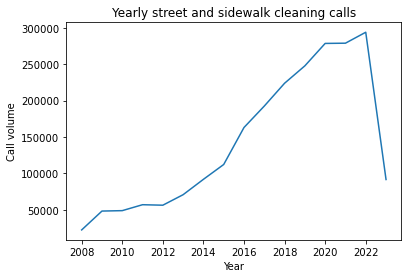

In [60]:
ssc_df['year'].value_counts().sort_index().plot()
plt.title("Yearly street and sidewalk cleaning calls")
plt.xlabel("Year")
plt.ylabel("Call volume")
plt.show()

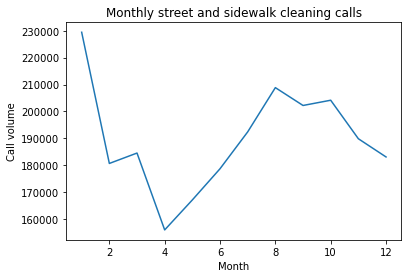

In [66]:
ssc_df['Month'].value_counts().sort_index().plot()
plt.title("Monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

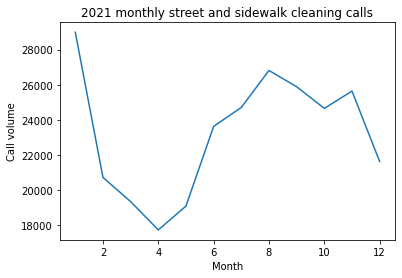

In [67]:
df_2021 = ssc_df[ssc_df['year']==2021]
df_2021['Month'].value_counts().sort_index().plot()
plt.title("2021 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

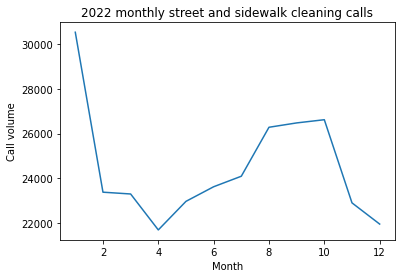

In [68]:
df_2022 = ssc_df[ssc_df['year']==2022]
df_2022['Month'].value_counts().sort_index().plot()
plt.title("2022 monthly street and sidewalk cleaning calls")
plt.xlabel("Month")
plt.ylabel("Call volume")
plt.show()

## ARIMA

In [70]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [71]:
ssc_df['RoundTime'] = ssc_df['Opened'].apply(hour_rounder)

In [72]:
hourly_count = ssc_df.groupby('RoundTime')['CaseID'].count()

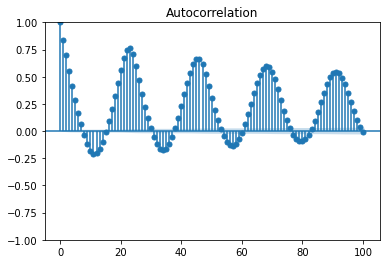

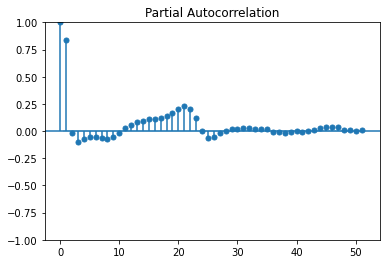

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(hourly_count.values.astype(float), lags=100, alpha=0.05)
plot_pacf(hourly_count.values.astype(float), method='ywm')
plt.show();

In [74]:
# Implement train test split here
X = hourly_count.values
# Doing an 80/20 split
split = int(len(X) * 0.80)
train, test = X[:split], X[split:]
train_dates, test_dates = hourly_count.index[:split], hourly_count.index[split:]

#### ARIMA (24,1,0)

In [84]:
model = ARIMA(train, order=(24,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                ARIMA(24, 1, 0)   Log Likelihood             -323969.872
Date:                Wed, 19 Apr 2023   AIC                         647989.744
Time:                        11:40:49   BIC                         648224.893
Sample:                             0   HQIC                        648061.451
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4322      0.001   -436.890      0.000      -0.434      -0.430
ar.L2         -0.3413      0.002   -151.620      0.000      -0.346      -0.337
ar.L3         -0.3699      0.003   -142.996      0.0

In [85]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.204


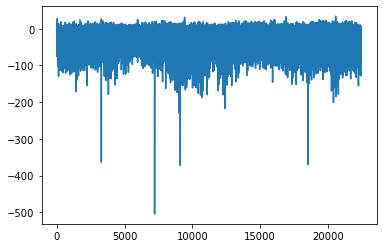

In [86]:
plt.plot(forecast-test)
plt.show();

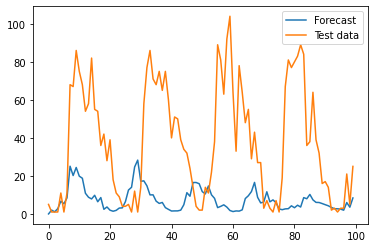

In [87]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [88]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

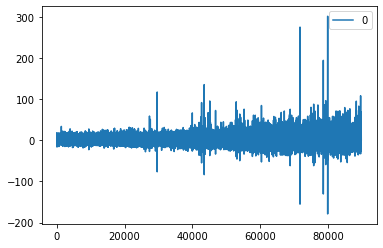

In [89]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

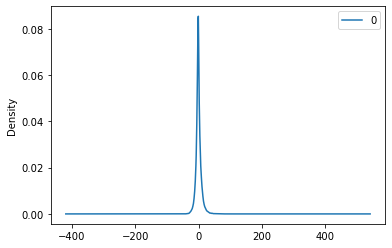

In [90]:
residuals.plot(kind='kde')

In [91]:
residuals.describe()

,0
count,89855.000000
mean,0.003295
std,8.904497
min,-178.886036
25%,-4.089102
50%,-0.770492
75%,3.285521
max,301.618058


#### ARIMA (8,1,0)

In [92]:
model = ARIMA(train, order=(8,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(8, 1, 0)   Log Likelihood             -339307.747
Date:                Wed, 19 Apr 2023   AIC                         678633.493
Time:                        11:42:23   BIC                         678718.147
Sample:                             0   HQIC                        678659.308
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1081      0.001   -112.051      0.000      -0.110      -0.106
ar.L2          0.0275      0.002     12.536      0.000       0.023       0.032
ar.L3         -0.0160      0.003     -6.348      0.0

In [93]:
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.259


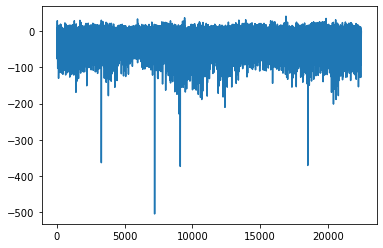

In [94]:
plt.plot(forecast-test)
plt.show();

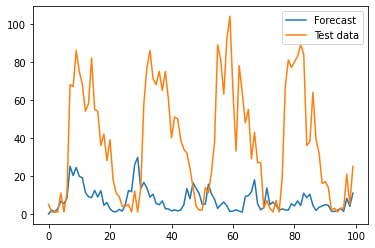

In [95]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [96]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

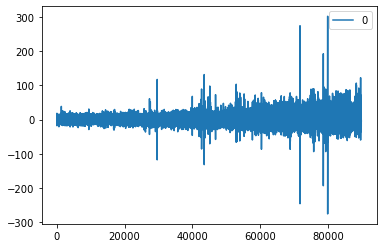

In [97]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

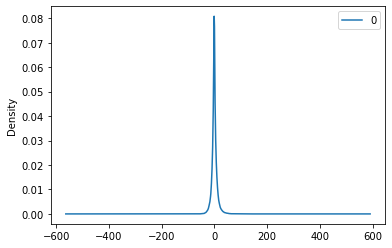

In [98]:
residuals.plot(kind='kde')

In [99]:
residuals.describe()

,0
count,89855.000000
mean,0.000318
std,10.562113
min,-275.193858
25%,-4.410721
50%,-0.618449
75%,3.646356
max,301.936924


#### Trying 1

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                89855
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -339794.694
Date:                Wed, 19 Apr 2023   AIC                         679593.387
Time:                        11:43:16   BIC                         679612.199
Sample:                             0   HQIC                        679599.124
                              - 89855                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      0.001   -108.054      0.000      -0.106      -0.102
sigma2       112.7752      0.149    757.972      0.000     112.484     113.067
Ljung-Box (L1) (Q):                   1.12   Jarque-

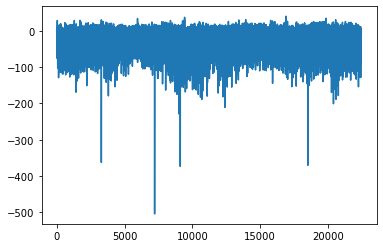

In [100]:
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(end=len(test)-1)
rmse = np.sqrt(mean_squared_error(forecast, test))
print('Test RMSE: %.3f' % rmse)
plt.plot(forecast-test)
plt.show();

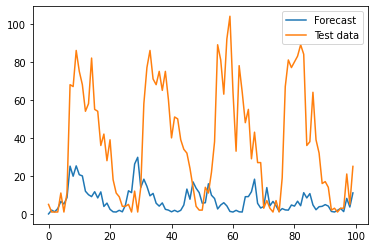

In [101]:
plt.plot(forecast[:100], label='Forecast')
plt.plot(test[:100], label='Test data')
plt.legend();

In [102]:
residuals = pd.DataFrame(model_fit.resid)

<AxesSubplot:>

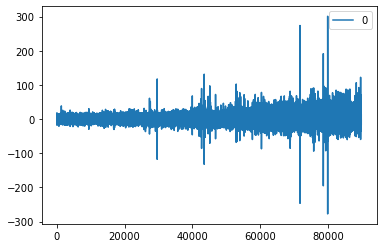

In [103]:
residuals.plot()

<AxesSubplot:ylabel='Density'>

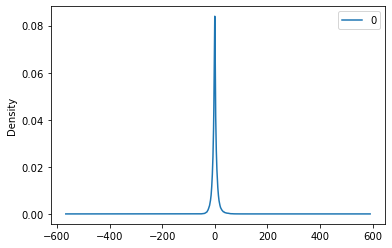

In [104]:
residuals.plot(kind='kde')

In [105]:
residuals.describe()

,0
count,89855.000000
mean,0.000174
std,10.619510
min,-277.411652
25%,-4.312756
50%,-0.293543
75%,3.582992
max,301.123464


### Trying auto-arima

In [ ]:
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=8, max_q=2, m=1,
                           seasonal=True,
                           d=0, trace=True,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

model.fit(train)

prediction1 = model.predict(n_periods=len(train))
prediction2 = model.predict(n_periods=len(test))

#plot the predictions for validation set
# plt.plot(time_train,train, label='train')
# plt.plot(time_test,test, label='test')
# plt.plot(time_train, prediction1, label='prediction1')
# plt.plot(time_test, prediction2, label='prediction2')
# plt.legend()
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=672781.870, Time=12.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=779863.233, Time=1.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=672818.180, Time=1.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=722518.095, Time=8.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=832321.319, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=672526.585, Time=33.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=672771.065, Time=2.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=670130.373, Time=43.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=671564.356, Time=2.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=670090.195, Time=58.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=670954.866, Time=3.33 sec


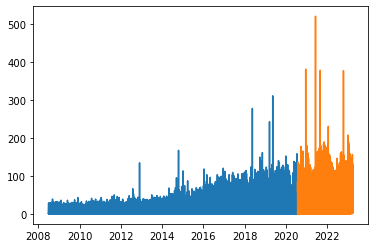

In [87]:
plt.plot(hourly_count[:split].index, train, label='train')
plt.plot(hourly_count[:split].index, prediction1, label='prediction1')
plt.plot(hourly_count[split:].index, test, label='test')
plt.plot(hourly_count[:split].index, prediction2, label='prediction2')
plt.legend()
plt.show()

### ARIMA TO-DOs
* Tune model, train/test RMSE
* Zip-code dummies
* Baseline - historical average for that date?

*Models to build:*
 * General volume
 * Garbage can overflowing
 * General cleaning
 * Bulky items
 
*Data Restrictions*
 * Use street cleaning category
 * Years: 2016-present (April 1st, 2023)

*Features to include:*
 * minute
 * day
 * hour
 * hour lags (hours 6-12)
 * ACS census tract data
 